##Project 7: Market Basket
### Nishat Ahmed, Seyun Kim and Lucia Rhode
Select a dataset of interest to you and perform a market basket analysis, including finding frequent itemsets and mining association rules. Do not use a shopping cart dataset - select(or create) another kind of dataset and think of how to frame it as a market basket problem. You can use whatever implemtation of the A Priori algorithm you want, from the book, from here: http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/, or anything else you find.

There are no performance goals to meet as this is a data mining project, but the model does need to be carefuly tuned to select frequent itemsets and association rules with high support, confidence and lift.  Your write-up should discuss what dataset you chose and why, what parameters you selected and why, give examples of itemsets and rules. You should wrap it up with a conclusion about what you 'discovered' about this dataset using this method.

In [3]:
import pandas as pd
import numpy as np
import math

In [ ]:
from google.colab import files
files.upload()

For project 7, we wanted to show how market basket analysis can be used in the medical field. We chose to perform market basket analysis on a dataset of diseases and symptoms to see which symptoms are frequently associated with each other.

In [4]:
# Load shopping cart dataset
raw_data = pd.read_csv("/content/Symptoms.csv")

In [5]:
raw_data.head()

,Disease,Count of Disease Occurrence,Symptom
0,UMLS:C0020538_hypertensive disease,3363.0,UMLS:C0008031_pain chest
1,NaN,NaN,UMLS:C0392680_shortness of breath
2,NaN,NaN,UMLS:C0012833_dizziness
3,NaN,NaN,UMLS:C0004093_asthenia
4,NaN,NaN,UMLS:C0085639_fall


#Data Cleaning

In [6]:
symptoms = raw_data["Symptom"].str.split("_", expand = True)
symptoms = symptoms[1].str.split("^", expand = True)

In [7]:
data = raw_data

In [8]:
data['Symptom'] = symptoms[0]

In [9]:
data['Symptom'][data['Symptom'] == '']

309    
Name: Symptom, dtype: object

In [10]:
data['Symptom'][data['Symptom'].isnull()]

1622    NaN
1866    NaN
Name: Symptom, dtype: object

In [11]:
data = data.drop([309, 1622, 1866], axis=0)

In [12]:
data

,Disease,Count of Disease Occurrence,Symptom
0,UMLS:C0020538_hypertensive disease,3363.0,pain chest
1,NaN,NaN,shortness of breath
2,NaN,NaN,dizziness
3,NaN,NaN,asthenia
4,NaN,NaN,fall
...,...,...,...
1861,NaN,NaN,bedridden
1862,NaN,NaN,prostatism
1863,UMLS:C0011127_decubitus ulcer,42.0,systolic murmur
1864,NaN,NaN,frail


In [13]:
temp = data['Disease'].str.split("_", expand = True)
disease = temp[1].str.split("^", expand = True)

In [14]:
data['Disease'] = disease[0]

In [15]:
data = data.drop('Count of Disease Occurrence', axis=1)

In [16]:
data.head()

,Disease,Symptom
0,hypertensive disease,pain chest
1,NaN,shortness of breath
2,NaN,dizziness
3,NaN,asthenia
4,NaN,fall


In [17]:
disease_name = np.delete(data['Disease'].unique(), 1, 0)

In [18]:
data = data.fillna(method='ffill')

In [19]:
data

,Disease,Symptom
0,hypertensive disease,pain chest
1,hypertensive disease,shortness of breath
2,hypertensive disease,dizziness
3,hypertensive disease,asthenia
4,hypertensive disease,fall
...,...,...
1861,affect labile,bedridden
1862,affect labile,prostatism
1863,decubitus ulcer,systolic murmur
1864,decubitus ulcer,frail


#Describing the dataset

The disease and symptoms dataset includes 134 diseases and 396 symptoms. Bipolar disorder has the most associated symptoms.

In [20]:
data.describe()

,Disease,Symptom
count,1864,1864
unique,134,396
top,bipolar disorder,shortness of breath
freq,28,46


In [21]:
data

,Disease,Symptom
0,hypertensive disease,pain chest
1,hypertensive disease,shortness of breath
2,hypertensive disease,dizziness
3,hypertensive disease,asthenia
4,hypertensive disease,fall
...,...,...
1861,affect labile,bedridden
1862,affect labile,prostatism
1863,decubitus ulcer,systolic murmur
1864,decubitus ulcer,frail


In [39]:
#list all symptoms in the dataset
data['Symptom'].unique()

array(['pain chest', 'shortness of breath', 'dizziness', 'asthenia',
       'fall', 'syncope', 'vertigo', 'sweat', 'palpitation', 'nausea',
       'angina pectoris', 'pressure chest', 'polyuria', 'polydypsia',
       'orthopnea', 'rale', 'unresponsiveness', 'mental status changes',
       'vomiting', 'labored breathing', 'feeling suicidal', 'suicidal',
       'hallucinations auditory', 'feeling hopeless', 'weepiness',
       'sleeplessness', 'motor retardation', 'irritable mood', 'blackout',
       'mood depressed', 'hallucinations visual', 'worry', 'agitation',
       'tremor', 'intoxication', 'verbal auditory hallucinations',
       'energy increased', 'difficulty', 'nightmare',
       'unable to concentrate', 'homelessness', 'hypokinesia',
       'dyspnea on exertion', 'chest tightness', 'cough', 'fever',
       'decreased translucency', 'productive cough', 'pleuritic pain',
       'yellow sputum', 'breath sounds decreased', 'chill', 'rhonchus',
       'green sputum', 'non-productiv

In [23]:
count = data['Symptom'].value_counts()

<BarContainer object of 396 artists>

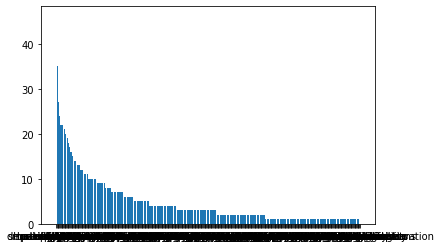

In [37]:
from matplotlib import pyplot as plt

plt.bar(count.index, count)

<BarContainer object of 20 artists>

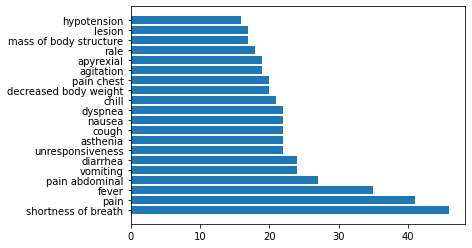

In [38]:
# top 20 most common symptoms
plt.barh(count.index[:20], count[:20])

#Formatting dataset for basket anaylsis

In [40]:
dataset = []
for i, id in enumerate(disease_name):
  element = data[data['Disease']==id]['Symptom'].to_numpy()
  dataset.append(element)
dataset = np.array(dataset)

<ipython-input-40-5eaaf01a5cf5>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dataset = np.array(dataset)


In [41]:
dataset

array([array(['pain chest', 'shortness of breath', 'dizziness', 'asthenia',
              'fall', 'syncope', 'vertigo', 'sweat', 'palpitation', 'nausea',
              'angina pectoris', 'pressure chest'], dtype=object)            ,
       array(['polyuria', 'polydypsia', 'shortness of breath', 'pain chest',
              'asthenia', 'nausea', 'orthopnea', 'rale', 'sweat',
              'unresponsiveness', 'mental status changes', 'vertigo', 'vomiting',
              'labored breathing'], dtype=object)                                ,
       array(['feeling suicidal', 'suicidal', 'hallucinations auditory',
              'feeling hopeless', 'weepiness', 'sleeplessness',
              'motor retardation', 'irritable mood', 'blackout',
              'mood depressed', 'hallucinations visual', 'worry', 'agitation',
              'tremor', 'intoxication', 'verbal auditory hallucinations',
              'energy increased', 'difficulty', 'nightmare',
              'unable to concentrate', 'hom

In [42]:
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_, index=disease_name)
df

,Heberden's node,Murphy's sign,Stahli's line,abdomen acute,abdominal bloating,abdominal tenderness,abnormal sensation,abnormally hard consistency,abortion,abscess bacterial,...,vision blurred,vomiting,weepiness,weight gain,welt,wheelchair bound,wheezing,withdraw,worry,yellow sputum
hypertensive disease,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
diabetes,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
depression mental,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
coronary arteriosclerosis,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
pneumonia,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ileus,False,False,False,True,False,True,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
adhesion,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
delusion,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,True,False
affect labile,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#Market Basket Analysis

*following http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/*

In [43]:
from mlxtend.frequent_patterns import apriori

apriori(df, min_support=0.2)

,support,itemsets
0,0.253731,(118)
1,0.305970,(248)
2,0.201493,(249)
3,0.343284,(322)


In [44]:
#decrease min_support to get more itemsets
apriori(df, min_support=0.06)

,support,itemsets
0,0.134328,(14)
1,0.067164,(19)
2,0.141791,(23)
3,0.074627,(25)
4,0.164179,(27)
...,...,...
110,0.067164,"(194, 347, 143)"
111,0.067164,"(248, 249, 229)"
112,0.074627,"(249, 387, 229)"
113,0.067164,"(298, 244, 322)"


In [45]:
frequent_itemsets = apriori(df, min_support=0.06, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.134328,(agitation),1
1,0.067164,(angina pectoris),1
2,0.141791,(apyrexial),1
3,0.074627,(ascites),1
4,0.164179,(asthenia),1
...,...,...,...
110,0.067164,"(suicidal, irritable mood, hallucinations audi...",3
111,0.067164,"(nausea, pain, pain abdominal)",3
112,0.074627,"(nausea, vomiting, pain abdominal)",3
113,0.067164,"(rale, orthopnea, shortness of breath)",3


Looking through the following frequent itemsets, they logically make a lot of sense, for example:

(vomiting, pain abdominal)

(irritable mood, agitation)

(shortness of breath, cough)

(vomiting, nausea)

(shortness of breath, pain chest, sweat)

etc.

In [46]:
frequent_itemsets[(frequent_itemsets['length'] >= 2) &
                  (frequent_itemsets['support'] >= 0.06)]

,support,itemsets,length
64,0.074627,"(agitation, hallucinations auditory)",2
65,0.074627,"(irritable mood, agitation)",2
66,0.067164,"(suicidal, agitation)",2
67,0.067164,"(tremor, agitation)",2
68,0.067164,"(agitation, worry)",2
69,0.074627,"(pain, apyrexial)",2
70,0.104478,"(fever, chill)",2
71,0.067164,"(fever, cough)",2
72,0.074627,"(shortness of breath, cough)",2
73,0.074627,"(fever, diarrhea)",2


In [47]:
frequent_itemsets[(frequent_itemsets['length'] >= 3) &
                  (frequent_itemsets['support'] >= 0.06)]

,support,itemsets,length
109,0.067164,"(irritable mood, agitation, hallucinations aud...",3
110,0.067164,"(suicidal, irritable mood, hallucinations audi...",3
111,0.067164,"(nausea, pain, pain abdominal)",3
112,0.074627,"(nausea, vomiting, pain abdominal)",3
113,0.067164,"(rale, orthopnea, shortness of breath)",3
114,0.067164,"(pain chest, shortness of breath, sweat)",3


#Check support, confidence and lift

In [48]:
from mlxtend.frequent_patterns import association_rules

support = association_rules(frequent_itemsets, metric="support", min_threshold=0.1)
display(support)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fever),(chill),0.253731,0.149254,0.104478,0.411765,2.758824,0.066607,1.446269
1,(chill),(fever),0.149254,0.253731,0.104478,0.700000,2.758824,0.066607,2.487562
2,(dyspnea),(shortness of breath),0.164179,0.343284,0.134328,0.818182,2.383399,0.077968,3.611940
3,(shortness of breath),(dyspnea),0.343284,0.164179,0.134328,0.391304,2.383399,0.077968,1.373134
4,(nausea),(pain abdominal),0.164179,0.201493,0.111940,0.681818,3.383838,0.078859,2.509595
5,(pain abdominal),(nausea),0.201493,0.164179,0.111940,0.555556,3.383838,0.078859,1.880597
6,(nausea),(vomiting),0.164179,0.179104,0.104478,0.636364,3.553030,0.075072,2.257463
7,(vomiting),(nausea),0.179104,0.164179,0.104478,0.583333,3.553030,0.075072,2.005970
8,(pain),(pain abdominal),0.305970,0.201493,0.111940,0.365854,1.815718,0.050290,1.259185
9,(pain abdominal),(pain),0.201493,0.305970,0.111940,0.555556,1.815718,0.050290,1.561567


In [49]:
confidence = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
display(confidence)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(agitation),(hallucinations auditory),0.134328,0.104478,0.074627,0.555556,5.317460,0.060593,2.014925
1,(hallucinations auditory),(agitation),0.104478,0.134328,0.074627,0.714286,5.317460,0.060593,3.029851
2,(irritable mood),(agitation),0.082090,0.134328,0.074627,0.909091,6.767677,0.063600,9.522388
3,(agitation),(irritable mood),0.134328,0.082090,0.074627,0.555556,6.767677,0.063600,2.065299
4,(suicidal),(agitation),0.089552,0.134328,0.067164,0.750000,5.583333,0.055135,3.462687
...,...,...,...,...,...,...,...,...,...
70,(orthopnea),"(rale, shortness of breath)",0.104478,0.097015,0.067164,0.642857,6.626374,0.057028,2.528358
71,"(pain chest, shortness of breath)",(sweat),0.111940,0.082090,0.067164,0.600000,7.309091,0.057975,2.294776
72,"(pain chest, sweat)",(shortness of breath),0.074627,0.343284,0.067164,0.900000,2.621739,0.041546,6.567164
73,"(shortness of breath, sweat)",(pain chest),0.074627,0.149254,0.067164,0.900000,6.030000,0.056026,8.507463


In [50]:
lift = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
display(lift)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(agitation),(hallucinations auditory),0.134328,0.104478,0.074627,0.555556,5.317460,0.060593,2.014925
1,(hallucinations auditory),(agitation),0.104478,0.134328,0.074627,0.714286,5.317460,0.060593,3.029851
2,(irritable mood),(agitation),0.082090,0.134328,0.074627,0.909091,6.767677,0.063600,9.522388
3,(agitation),(irritable mood),0.134328,0.082090,0.074627,0.555556,6.767677,0.063600,2.065299
4,(suicidal),(agitation),0.089552,0.134328,0.067164,0.750000,5.583333,0.055135,3.462687
...,...,...,...,...,...,...,...,...,...
115,"(pain chest, sweat)",(shortness of breath),0.074627,0.343284,0.067164,0.900000,2.621739,0.041546,6.567164
116,"(shortness of breath, sweat)",(pain chest),0.074627,0.149254,0.067164,0.900000,6.030000,0.056026,8.507463
117,(pain chest),"(shortness of breath, sweat)",0.149254,0.074627,0.067164,0.450000,6.030000,0.056026,1.682497
118,(shortness of breath),"(pain chest, sweat)",0.343284,0.074627,0.067164,0.195652,2.621739,0.041546,1.150464


In [51]:
high_lift_support=pd.merge(lift,support, how='inner')
display(high_lift_support)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(fever),(chill),0.253731,0.149254,0.104478,0.411765,2.758824,0.066607,1.446269
1,(chill),(fever),0.149254,0.253731,0.104478,0.700000,2.758824,0.066607,2.487562
2,(dyspnea),(shortness of breath),0.164179,0.343284,0.134328,0.818182,2.383399,0.077968,3.611940
3,(shortness of breath),(dyspnea),0.343284,0.164179,0.134328,0.391304,2.383399,0.077968,1.373134
4,(nausea),(pain abdominal),0.164179,0.201493,0.111940,0.681818,3.383838,0.078859,2.509595
5,(pain abdominal),(nausea),0.201493,0.164179,0.111940,0.555556,3.383838,0.078859,1.880597
6,(nausea),(vomiting),0.164179,0.179104,0.104478,0.636364,3.553030,0.075072,2.257463
7,(vomiting),(nausea),0.179104,0.164179,0.104478,0.583333,3.553030,0.075072,2.005970
8,(pain),(pain abdominal),0.305970,0.201493,0.111940,0.365854,1.815718,0.050290,1.259185
9,(pain abdominal),(pain),0.201493,0.305970,0.111940,0.555556,1.815718,0.050290,1.561567


In [52]:
high_confidence_lift_support=pd.merge(confidence,high_lift_support, how='inner')
display(high_confidence_lift_support)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(chill),(fever),0.149254,0.253731,0.104478,0.700000,2.758824,0.066607,2.487562
1,(dyspnea),(shortness of breath),0.164179,0.343284,0.134328,0.818182,2.383399,0.077968,3.611940
2,(nausea),(pain abdominal),0.164179,0.201493,0.111940,0.681818,3.383838,0.078859,2.509595
3,(pain abdominal),(nausea),0.201493,0.164179,0.111940,0.555556,3.383838,0.078859,1.880597
4,(nausea),(vomiting),0.164179,0.179104,0.104478,0.636364,3.553030,0.075072,2.257463
5,(vomiting),(nausea),0.179104,0.164179,0.104478,0.583333,3.553030,0.075072,2.005970
6,(pain abdominal),(pain),0.201493,0.305970,0.111940,0.555556,1.815718,0.050290,1.561567
7,(pain chest),(shortness of breath),0.149254,0.343284,0.111940,0.750000,2.184783,0.060704,2.626866


The above shows a list of item pairs with high support, confidence and lift. The relationships shown in the output aren't particularly surprising, but they do show how market basket analysis could be used in healthcare to identify common symptom patterns. For example the item pairs (vomiting, nausea) and (nausea, vomiting) indicate that nausea and vomiting are closely associated symptoms.

Further use of market basket analysis in healthcare could be used to identify common patterns in treatment plans, risk factors, patients' medical histories, etc.